In [1]:
# Import the required libraries.
import os
import cv2
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

**Visualize Data**

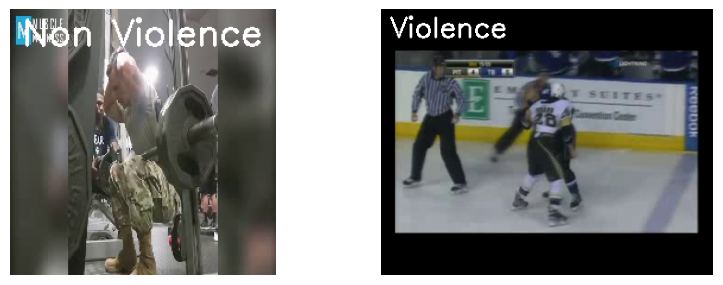

In [2]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('F:\DSGP\Violence Detection\Dataset')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'F:\DSGP\Violence Detection\Dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'F:\DSGP\Violence Detection\Dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

# Extracting Frames

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 112, 112
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
NUM_FRAMES = 16
 

DATASET_DIR = "F:\DSGP\Violence Detection\Dataset"
 
CLASSES_LIST = ["Non Violence","Violence"]

OUTPUT_PATH = 'F:\DSGP\Violence Detection\Data Frames/'

In [4]:
def frames_extraction(video_path):
 
    frames_list = []
    c = 0
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/NUM_FRAMES), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(NUM_FRAMES):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break

        cv2.imwrite(OUTPUT_PATH + str(c) + '.jpg', frame)
        c += 1
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    print('Done ' + str(video_path))
    video_reader.release()
 
    return frames_list

# Creating the Data

In [5]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the NUM_FRAMES specified.
            # So ignore the vides having frames less than the NUM_FRAMES.
            if len(frames) == NUM_FRAMES:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Non Violence
Done F:\DSGP\Violence Detection\Dataset\Non Violence\1.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\10.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\11.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\12.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\13.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\14.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\15.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\16.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\17.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\18.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\19.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\2.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\20.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\21.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\22.mp4
Done F:\DSGP\Violence Detection\Dataset\Non Violence\23.mp4
Don

In [7]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [8]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# Encoding and Splitting Training-Testing Sets

In [9]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
one_hot_encoded_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = 42)

In [12]:
features_train[0].shape

(16, 112, 112, 3)

In [13]:
features_test[1].shape

(16, 112, 112, 3)

In [14]:
labels_train[0]

array([1., 0.], dtype=float32)

In [15]:
print(features_train.shape,labels_train.shape)
print(features_test.shape, labels_test.shape)

(1601, 16, 112, 112, 3) (1601, 2)
(178, 16, 112, 112, 3) (178, 2)


# Importing MobileNet and Fine-Tuning it.

In [16]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
    layer.trainable=False

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

# Building The Model

In [21]:
from keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Dense, Dropout, Flatten
def create_model():

    model = Sequential()

    ########################################################################################################################

    #Specifying Input to match features shape
    model.add(Input(shape = (NUM_FRAMES, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.5))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.5))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    model.summary()

    return model

In [23]:
# Construct the model.
Violence_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(Violence_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 16, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 dropout_6 (Dropout)         (None, 16, 3, 3, 1280)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 11520)        0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               2957568   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

# Specifying Callbacks and Fitting

In [24]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
Violence_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
# Fitting the model 
Violence_model_history = Violence_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
160/160 [==============================] - 135s 804ms/step - loss: 0.7424 - accuracy: 0.4859 - val_loss: 0.6937 - val_accuracy: 0.4953 - lr: 0.0100
Epoch 2/50
160/160 [==============================] - 121s 758ms/step - loss: 0.7077 - accuracy: 0.5211 - val_loss: 0.6877 - val_accuracy: 0.5545 - lr: 0.0100
Epoch 3/50
160/160 [==============================] - 123s 767ms/step - loss: 0.6949 - accuracy: 0.5328 - val_loss: 0.6869 - val_accuracy: 0.5670 - lr: 0.0100
Epoch 4/50
160/160 [==============================] - 122s 761ms/step - loss: 0.6903 - accuracy: 0.5289 - val_loss: 0.6817 - val_accuracy: 0.5265 - lr: 0.0100
Epoch 5/50
160/160 [==============================] - 121s 755ms/step - loss: 0.6874 - accuracy: 0.5453 - val_loss: 0.6736 - val_accuracy: 0.6449 - lr: 0.0100
Epoch 6/50
160/160 [==============================] - 120s 753ms/step - loss: 0.6646 - accuracy: 0.5961 - val_loss: 0.6442 - val_accuracy: 0.7601 - lr: 0.0100
Epoch 7/50
160/160 [==========================

In [26]:
Violence_model.save('violence-detection_new_model.h5', overwrite=True, include_optimizer=True)

In [27]:
model_evaluation_history = Violence_model.evaluate(features_test, labels_test)

6/6 [==============================] - 7s 1s/step - loss: 0.4150 - accuracy: 0.9157


# Model Evaluation

In [28]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

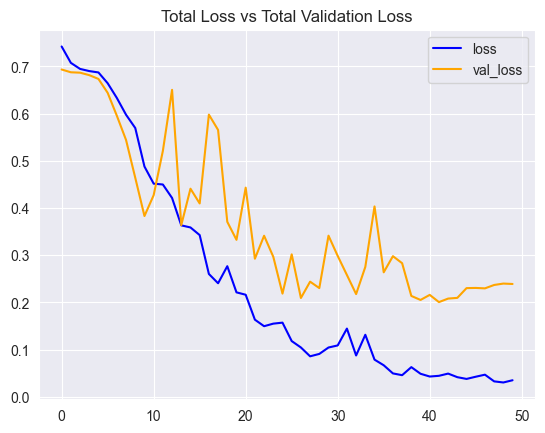

In [29]:
plot_metric(Violence_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

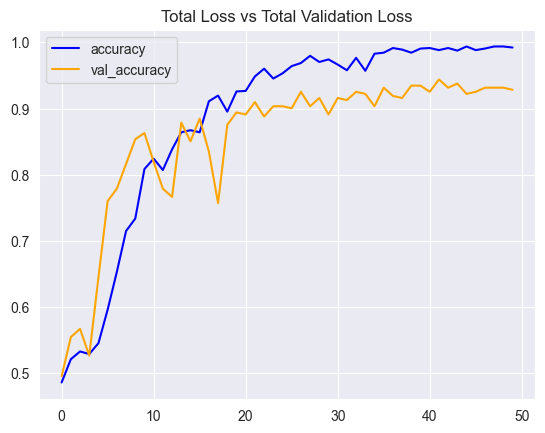

In [30]:
plot_metric(Violence_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# Predicting the Test Set

In [31]:
labels_predict = Violence_model.predict(features_test)

6/6 [==============================] - 8s 1s/step


In [32]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [33]:
labels_test_normal.shape , labels_predict.shape

((178,), (178,))

Accuracy Score

In [34]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9157303370786517


Confusion Matrix

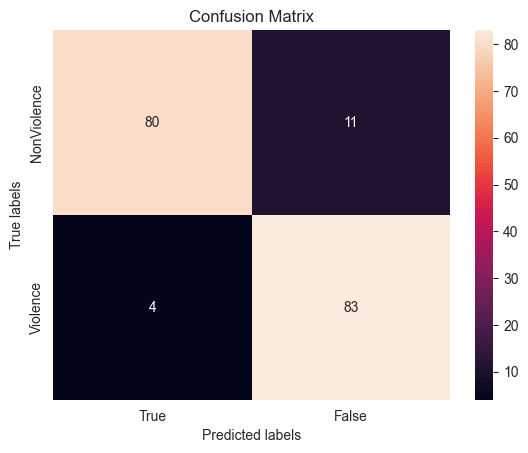

In [35]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Classification Report

In [36]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91        91
           1       0.88      0.95      0.92        87

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178

